# Multiple Linear Regression
## Housing Case Study

#### Problem Statement:

Consider a real estate company that has a dataset containing the prices of properties in the Delhi region. It wishes to use the data to optimise the sale prices of the properties based on important factors such as area, bedrooms, parking, etc.

Essentially, the company wants —


- To identify the variables affecting house prices, e.g. area, number of rooms, bathrooms, etc.

- To create a linear model that quantitatively relates house prices with variables such as number of rooms, area, number of bathrooms, etc.

- To know the accuracy of the model, i.e. how well these variables can predict house prices.

**So interpretation is important!**

## Import Dependencies

In [485]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [486]:
import warnings
warnings.filterwarnings('ignore')

## 1. Load dataset and analyse

In [487]:
housing = pd.read_csv('Housing.csv')
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [488]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
price               545 non-null int64
area                545 non-null int64
bedrooms            545 non-null int64
bathrooms           545 non-null int64
stories             545 non-null int64
mainroad            545 non-null object
guestroom           545 non-null object
basement            545 non-null object
hotwaterheating     545 non-null object
airconditioning     545 non-null object
parking             545 non-null int64
prefarea            545 non-null object
furnishingstatus    545 non-null object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [489]:
housing.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


## 2. Visualising the data

### 2.1. Visualise scatter plots among all numeric variables

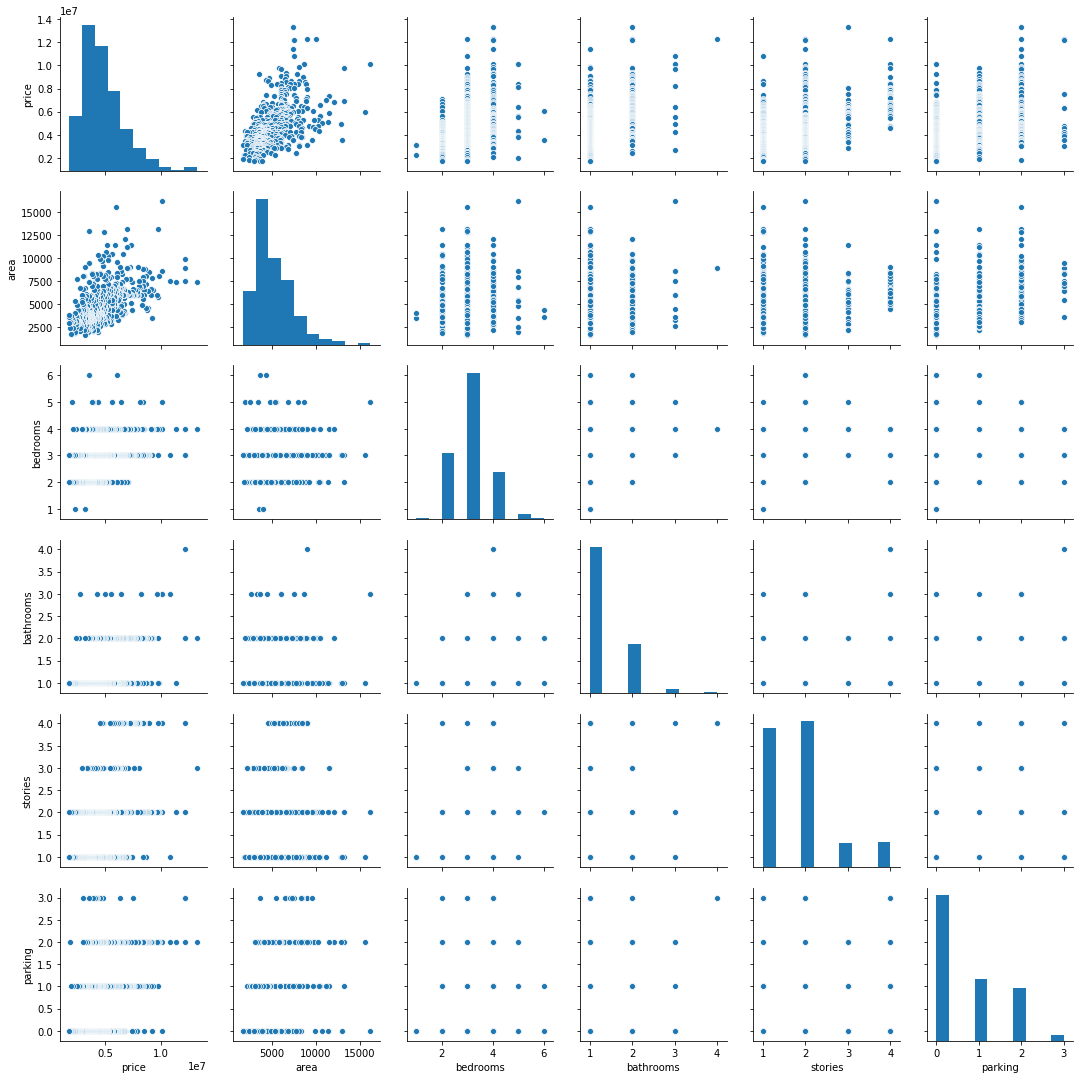

In [490]:
sns.pairplot(housing)
plt.show()

### 2.2. Visualising sprea of price against the categorical variables

In [491]:
cat_vars = ['mainroad', 'guestroom', 'basement', 
            'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

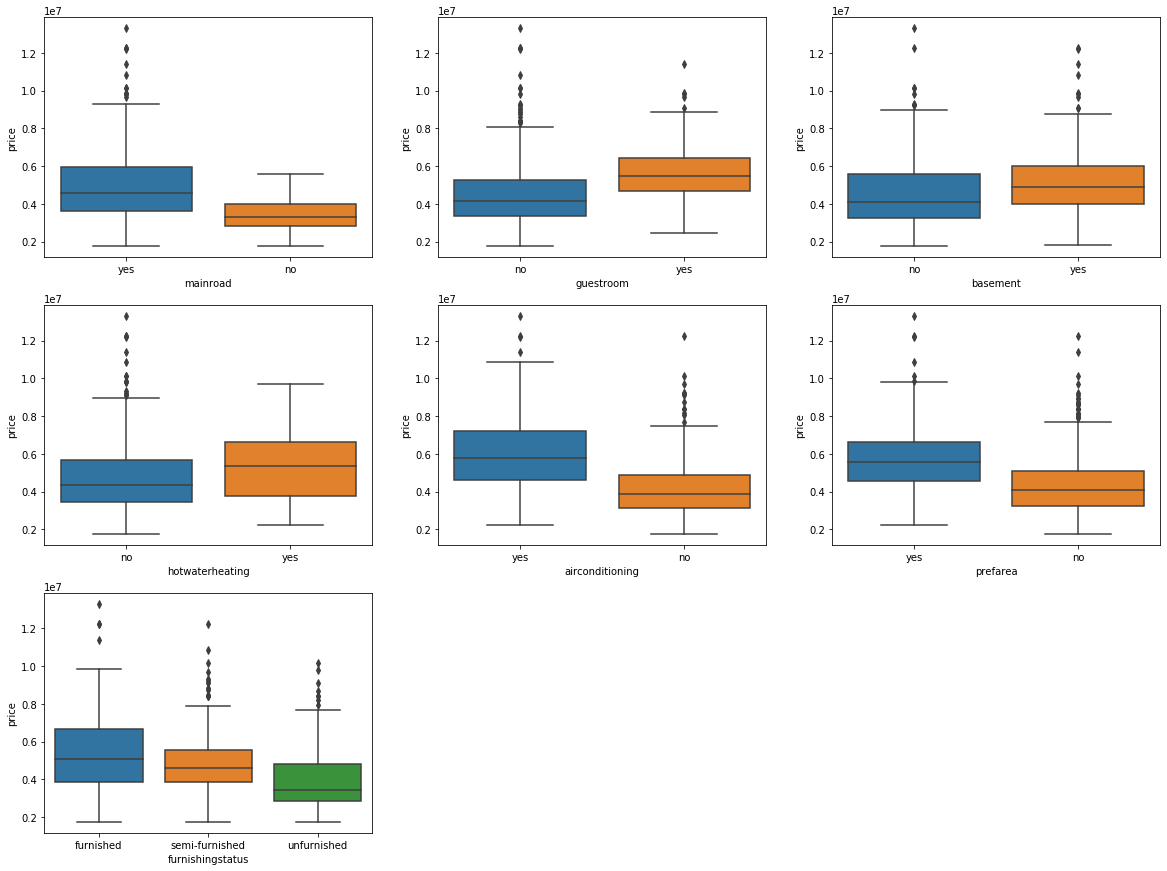

In [492]:
fig_width = 20
fig_height = 15
plt.figure(figsize=[fig_width,fig_height])

for index, cat_var in enumerate(cat_vars):
    plt.subplot(3,3,index + 1)
    sns.boxplot(x=cat_var, y='price', data=housing)

## 3. Data preprocessing

### 3.1. Convert binary features to numeric
- ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

In [493]:
def binary_to_numerical(column):
    '''
    Given a binary column, maps 'yes' to 1 and 'no' to 0
    '''
    return column.apply(lambda x: 1 if x=='yes' else 0)

In [494]:
# Apply binary_to_numerical to all binary columns
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
housing[binary_columns] = housing[binary_columns].apply(binary_to_numerical)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


### 3.2 Convert categorical variables to one hot encoding
- Observed that `furnishingstatus` is a categorical variable which could potentially have more than 2 levels 

In [495]:
# Find out unique levels in the furnishingstatus column
housing['furnishingstatus'].unique()

array(['furnished', 'semi-furnished', 'unfurnished'], dtype=object)

In [496]:
# Demo of what get_dummies do to a categorical column
pd.get_dummies(housing['furnishingstatus']).head()

,furnished,semi-furnished,unfurnished
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0


In [497]:
# Now lets use get_dummies and drop one column and append it to the housing dataframe
status = pd.get_dummies(housing['furnishingstatus'], drop_first=True)
housing = pd.concat([housing, status], axis=1)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [498]:
# Now we can drop furnishingstatus as we have dummies for it.
housing = housing.drop(columns=['furnishingstatus'])
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


## 3. Splitting dataset into train and test

In [499]:
# We set random seed and random_state so that our results are reproducible
np.random.seed(0)
df_train, df_test = train_test_split(housing, train_size=0.7, random_state=100)

## 4. Scaling the dataset
- We use MinMaxScaler for our case
- We shall scale only the continous variables, as scaling binary variables is not going to affect them.
    - ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
- First we fit scaler on train set and then transform the test set on this scale

A few notes on scaling:
- Scaling doesnt affect the model.
- It affects the unit of coefficients.
- The Standardisation interprets that y = intercept, when all variables have their value set to their means(i.e x - mean = 0)
- The Normalisation interprets that y = intercept, when all variables have their value set to their min values(i.e x - min(x) = 0)

In [500]:
scaler = MinMaxScaler()
numeric_columns = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']

In [501]:
df_train[numeric_columns] = scaler.fit_transform(df_train[numeric_columns])

In [502]:
df_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


In [503]:
df_train.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
count,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000,381.000000
mean,0.260333,0.288710,0.386352,0.136483,0.268591,0.855643,0.170604,0.351706,0.052493,0.299213,0.242345,0.233596,0.414698,0.325459
std,0.157607,0.181420,0.147336,0.237325,0.295001,0.351913,0.376657,0.478131,0.223313,0.458515,0.285933,0.423674,0.493318,0.469162
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.151515,0.155227,0.200000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.221212,0.234424,0.400000,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.345455,0.398099,0.400000,0.500000,0.333333,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Lets plot heatmap to view correlation

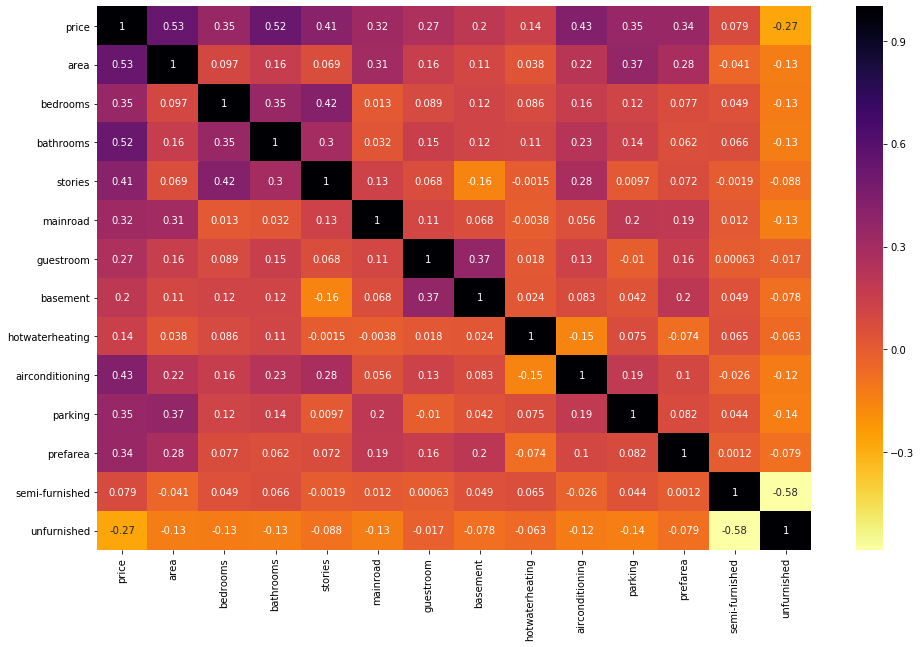

In [504]:
plt.figure(figsize=(16,10))
sns.heatmap(df_train.corr(), annot=True, cmap='inferno_r')
plt.show()

We can clearly see that `price` is correlated with `area` the most. Lets plot a scatterplot of `price` vs `area`.

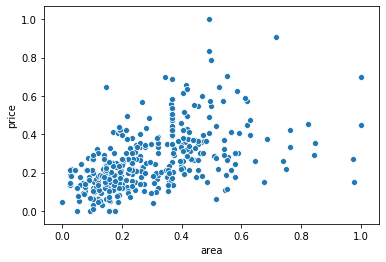

In [505]:
sns.scatterplot(x=df_train.area, y=df_train.price)
plt.show()

## 5. Dividing train into X and y for the model building 

In [506]:
y_train = df_train.pop('price')
X_train = df_train

## 6. Building a model using statsmodel using bottom up approach
- We build model with best variable. Then add another best variable and so on.
- The best variable in our case is `area`.

### 6.1. Building model with independent variable `area`.

#### 6.1.1. Adding constant with all values set to 1. This is an improvisation to get the intercept coefficient

In [507]:
X_train_sm = sm.add_constant(X_train[['area']])
X_train_sm.head()

,const,area
359,1.0,0.155227
19,1.0,0.403379
159,1.0,0.115628
35,1.0,0.454417
28,1.0,0.538015


#### 6.1.2. Fit model on the train dataset

In [508]:
ols_model = sm.OLS(y_train, X_train_sm)
reg_results_wrapper = ols_model.fit()
coeffs = reg_results_wrapper.params
coeffs

const    0.126894
area     0.462192
dtype: float64

#### 6.1.3. Plot scatterplot of `price` vs `area` and plot the fitted regression line on top

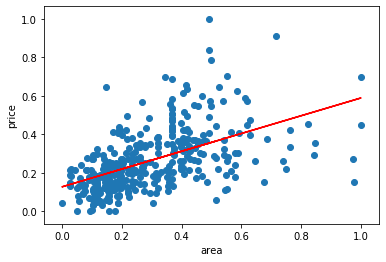

In [509]:
plt.scatter(x=X_train['area'], y=y_train)
y_pred_train = coeffs['const'] + coeffs['area'] * X_train['area']
plt.plot(X_train['area'], y_pred_train, 'r')
plt.xlabel('area')
plt.ylabel('price')
plt.show()

#### 6.1.4. View the summary

In [510]:
print(reg_results_wrapper.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     149.6
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           3.15e-29
Time:                        19:27:22   Log-Likelihood:                 227.23
No. Observations:                 381   AIC:                            -450.5
Df Residuals:                     379   BIC:                            -442.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1269      0.013      9.853      0.0

<b>Summary</b>: The r-square is 0.283 and adj r-square is 0.281. We can do better. Lets add one more param.

### 6.2. Building model with next best independent variable `bathrooms`.

#### 6.2.1. Adding constant with all values set to 1. This is an improvisation to get the intercept coefficient

In [511]:
X_train = df_train[['area', 'bathrooms']]
X_train_sm = sm.add_constant(X_train)

#### 6.2.2. Fit model on the train dataset

In [512]:
ols_model = sm.OLS(y_train, X_train_sm)
reg_results_wrapper = ols_model.fit()
coeffs = reg_results_wrapper.params
coeffs

const        0.104589
area         0.398396
bathrooms    0.298374
dtype: float64

#### 6.2.3 View the summary. We skip plotting as its now a 3D requirement henceforth

In [513]:
print(reg_results_wrapper.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     174.1
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           2.51e-54
Time:                        19:27:22   Log-Likelihood:                 288.24
No. Observations:                 381   AIC:                            -570.5
Df Residuals:                     378   BIC:                            -558.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1046      0.011      9.384      0.0

<b>Summary</b>: After adding param `bathrooms` the adj r-square increased from 0.281 to 0.477

### 6.3 Create a nice class to wraps all model building logic and params and summary

In [514]:
class OLS_Trainer:
    def __init__(self, X, y, independent_vars):
        self.X = X
        self.y = y
        self.independent_vars = independent_vars
        
    def fit(self):
        X_sm = sm.add_constant(self.X[self.independent_vars])
        ols_model = sm.OLS(y_train, X_sm)
        self.reg_results_wrapper = ols_model.fit()
        self.params = self.reg_results_wrapper.params
        
    def summary(self):
        return self.reg_results_wrapper.summary()
    
    def vif(self):
        vif_df = pd.DataFrame()
        vif_df['Features'] = self.independent_vars
        X_subset = pd.DataFrame(self.X[self.independent_vars])
        independent_vars_count = len(self.independent_vars)
        vif_df['VIF'] = [variance_inflation_factor(X_subset.values, index_var) for index_var in range(independent_vars_count)]
        vif_df['VIF'] = round(vif_df['VIF'], 2)
        vif_df = vif_df.sort_values(by='VIF', ascending=False)
        return vif_df
    
    def predict(self, X):
        X_sm = sm.add_constant(X[self.independent_vars])
        return self.reg_results_wrapper.predict(X_sm)
        

### 6.4. Building model with not next best independent variable `bedrooms`.

#### 6.4.1. Create and fit OLS_Trainer

In [515]:
ols_trainer = OLS_Trainer(df_train, y_train, ['area', 'bathrooms', 'bedrooms'])
ols_trainer.fit()
coeffs = ols_trainer.params
coeffs

const        0.041352
area         0.392211
bathrooms    0.259978
bedrooms     0.181863
dtype: float64

#### 6.4.2. View summary

In [516]:
print(ols_trainer.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     128.2
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           3.12e-57
Time:                        19:27:22   Log-Likelihood:                 297.76
No. Observations:                 381   AIC:                            -587.5
Df Residuals:                     377   BIC:                            -571.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0414      0.018      2.292      0.0

<b>Summary:</b>The adj r-square increased from 0.477 to 0.501 after adding `bedrooms` to the mix

### 6.5. Building model with all the variables

In [517]:
all_columns = list(df_train.columns)

In [518]:
ols_trainer = OLS_Trainer(df_train, y_train, all_columns)
ols_trainer.fit()
coeffs = ols_trainer.params
coeffs

const              0.020033
area               0.234664
bedrooms           0.046735
bathrooms          0.190823
stories            0.108516
mainroad           0.050441
guestroom          0.030428
basement           0.021595
hotwaterheating    0.084863
airconditioning    0.066881
parking            0.060735
prefarea           0.059428
semi-furnished     0.000921
unfurnished       -0.031006
dtype: float64

In [519]:
print(ols_trainer.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     60.40
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           8.83e-83
Time:                        19:27:22   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -735.6
Df Residuals:                     367   BIC:                            -680.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0200      0.021     

<b>Summary:</b> The adj r-square value increased to 0.670 after adding all variables.

<b>Objservations</b>:
- The p-val of many variables is high. Thus these variables could be insignificant.

Actions to take: Supplement this info with VIFs

In [520]:
ols_trainer.vif()

,Features,VIF
1,bedrooms,7.33
4,mainroad,6.02
0,area,4.67
3,stories,2.70
11,semi-furnished,2.19
9,parking,2.12
6,basement,2.02
12,unfurnished,1.82
8,airconditioning,1.77
2,bathrooms,1.67


We want a VIF of less than 5 for all variables. Clearly a few variables can be dropped.

### 6.6 Manual feature elimination

#### 6.6.1. Dropping variable named `semi-furnished` as it has a high p-val of `0.938`

In [521]:
all_columns.remove('semi-furnished')

In [522]:
ols_trainer = OLS_Trainer(df_train, y_train, all_columns)
ols_trainer.fit()
coeffs = ols_trainer.params
coeffs

const              0.020740
area               0.234404
bedrooms           0.046710
bathrooms          0.190876
stories            0.108475
mainroad           0.050401
guestroom          0.030447
basement           0.021605
hotwaterheating    0.084890
airconditioning    0.066803
parking            0.060761
prefarea           0.059419
unfurnished       -0.031594
dtype: float64

In [523]:
print(ols_trainer.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     65.61
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           1.07e-83
Time:                        19:27:22   Log-Likelihood:                 381.79
No. Observations:                 381   AIC:                            -737.6
Df Residuals:                     368   BIC:                            -686.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0207      0.019     

In [524]:
ols_trainer.vif()

,Features,VIF
1,bedrooms,6.59
4,mainroad,5.68
0,area,4.67
3,stories,2.69
9,parking,2.12
6,basement,2.01
8,airconditioning,1.77
2,bathrooms,1.67
10,prefarea,1.51
5,guestroom,1.47


#### 6.6.2. Dropping variable named `bedrooms` as it has a high p-val of `0.206` and high vif value of `6.59`

In [525]:
all_columns.remove('bedrooms')

In [526]:
ols_trainer = OLS_Trainer(df_train, y_train, all_columns)
ols_trainer.fit()
coeffs = ols_trainer.params
coeffs

const              0.035722
area               0.234746
bathrooms          0.196480
stories            0.117751
mainroad           0.048798
guestroom          0.030097
basement           0.023917
hotwaterheating    0.086403
airconditioning    0.066533
parking            0.062872
prefarea           0.059643
unfurnished       -0.032317
dtype: float64

In [527]:
print(ols_trainer.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     71.31
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           2.73e-84
Time:                        19:27:22   Log-Likelihood:                 380.96
No. Observations:                 381   AIC:                            -737.9
Df Residuals:                     369   BIC:                            -690.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0357      0.015     

In [528]:
ols_trainer.vif()

,Features,VIF
3,mainroad,4.79
0,area,4.55
2,stories,2.23
8,parking,2.10
5,basement,1.87
7,airconditioning,1.76
1,bathrooms,1.61
9,prefarea,1.50
4,guestroom,1.46
10,unfurnished,1.33


<b>Summary:</b> As you might have noticed, dropping `bedrooms` decreased the VIF of `mainroad` as well such that it is now under 5. But from the summary, we can still see some of them have a high p-value. `basement` for instance, has a p-value of 0.03. We should drop this variable as well.

### 6.6.3. Dropping variable named `basement` as it has a high p-val of `0.` 

In [529]:
all_columns.remove('basement')

In [530]:
ols_trainer = OLS_Trainer(df_train, y_train, all_columns)
ols_trainer.fit()
coeffs = ols_trainer.params
coeffs

const              0.042792
area               0.233517
bathrooms          0.201857
stories            0.108139
mainroad           0.049672
guestroom          0.040198
hotwaterheating    0.087618
airconditioning    0.068221
parking            0.062854
prefarea           0.063745
unfurnished       -0.033699
dtype: float64

In [531]:
print(ols_trainer.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     77.18
Date:                Tue, 01 Jun 2021   Prob (F-statistic):           3.13e-84
Time:                        19:27:22   Log-Likelihood:                 378.51
No. Observations:                 381   AIC:                            -735.0
Df Residuals:                     370   BIC:                            -691.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0428      0.014     

In [532]:
ols_trainer.vif()

,Features,VIF
3,mainroad,4.55
0,area,4.54
2,stories,2.12
7,parking,2.10
6,airconditioning,1.75
1,bathrooms,1.58
8,prefarea,1.47
9,unfurnished,1.33
4,guestroom,1.30
5,hotwaterheating,1.12


<b>Summary:</b> All the p-vals are low and VIFs are low as well. So we can stop eliminating the features manually.

### 6.7. Residual analysis

In [533]:
y_pred_train = ols_trainer.predict(df_train)

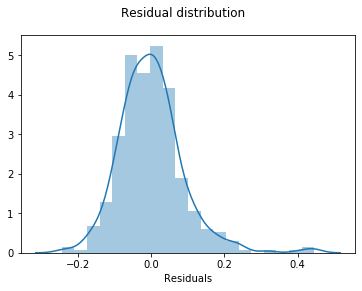

In [534]:
fig = plt.figure()
sns.distplot(y_train - y_pred_train, bins=20)
fig.suptitle('Residual distribution')
plt.xlabel('Residuals')
plt.show()

<b>Summary:</b> Residuals are normally distributed.

### 6.8. Testing the model

#### 6.8.1. Scale the test data

In [535]:
df_test[numeric_columns] = scaler.transform(df_test[numeric_columns])
df_test.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,0.229697,0.091869,0.4,0.0,0.333333,1,0,0,0,0,0.000000,1,1,0
54,0.484848,0.366420,0.4,0.5,0.333333,1,1,0,0,1,0.333333,0,1,0
171,0.303030,0.742080,0.4,0.0,0.000000,1,0,0,0,0,0.333333,1,1,0
244,0.242424,0.306582,0.4,0.0,0.333333,1,1,1,0,0,0.000000,1,1,0
268,0.227879,0.274023,0.6,0.0,0.333333,1,0,0,0,1,0.000000,0,1,0


In [536]:
df_test.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,0.263176,0.298548,0.408537,0.158537,0.268293,0.865854,0.195122,0.347561,0.030488,0.353659,0.205285,0.237805,0.420732,0.329268
std,0.172077,0.211922,0.147537,0.281081,0.276007,0.341853,0.397508,0.477654,0.172452,0.479569,0.289322,0.427043,0.495189,0.471387
min,0.006061,-0.016367,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142424,0.148011,0.400000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.226061,0.259724,0.400000,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.346970,0.397439,0.400000,0.500000,0.333333,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000,1.000000
max,0.909091,1.263992,0.800000,1.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 6.8.2. Split data into X and y

In [537]:
y_test = df_test.pop('price')
X_test = df_test

#### 6.8.3. Make prediction

In [538]:
y_pred_test = ols_trainer.predict(X_test)

#### 6.8.4. Model evaluation

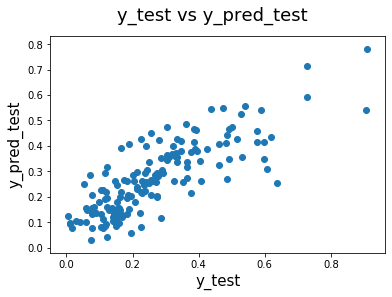

In [544]:
fig = plt.figure()
plt.scatter(y_test, y_pred_test)
fig.suptitle('y_test vs y_pred_test', fontsize=18)
plt.xlabel('y_test', fontsize=15)
plt.ylabel('y_pred_test', fontsize=15)
plt.show()

<b>Summary:</b> We have the scatterplot of y_test vs y_pred_test roughly in a diagonal. This is a good indication.

# Summary

We have a decent model but we could do better. 

The equatio of our best fitted line is as below:
$ price = 0.043 + 0.236  \times  area + 0.202  \times  bathrooms + 0.11 \times stories + 0.05 \times mainroad + 0.04 \times guestroom + 0.0876 \times hotwaterheating + 0.0682 \times airconditioning + 0.0629 \times parking + 0.0637 \times prefarea - 0.0337 \times unfurnished $

In [ ]:
const              0.042792
area               0.233517
bathrooms          0.201857
stories            0.108139
mainroad           0.049672
guestroom          0.040198
hotwaterheating    0.087618
airconditioning    0.068221
parking            0.062854
prefarea           0.063745
unfurnished       -0.033699